# CASO PRÁCTICO: ANÁLISIS DE UNA SERIE TEMPORAL. 
# TÉCNICAS CLÁSICAS E HÍBRIDAS.

Se han tomado datos de cuatro índices de mercados financieros medidos desde 1994 hasta 2018. Los índices sobre los que tenemos datos son:

- **S&P 500(Standard & Poor's 500)**: Es un ínidce que agrupa a 500 de las empresas más grandes y representativas de Estados Unidos. Se considera uno de los índices más importantes y una medida clave de la economía del país.
- **DAX (Deutscher Aktienindex)**: Principal índice bursátil de Alemania. Está compuesto por las 30 principales empresas cotizadas en la Bolsa de Frankfurt.
- **FTSE 100 (Financial Times Stock Exchange 100 Index)**: Es el índice que agrupa a las 100 empresas más grandes por capitalizaciónde mercado que cotizan en la Bolsa de Londres (LSE).
- **Nikkei 225**: Es uno de los índices más importantes de Japón, compuesto por las 225 principales empresas que cotizan en la Bolsa de Tokyo.

En este trabajo, se analizará el comportamiento del índice **DAX**, tratando de entender su tendencia, su volatilidad o su componente estacional (si la hubiera).

A continuación se importan las librerías que se necesitarán a lo largo del estudio.

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as sts
import scipy.stats
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch import arch_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


## PARTE 1: ANÁLISIS PREVIO

Cargamos el conjunto de datos y vemos el análisis descriptivo previo.

In [143]:
df = pd.read_csv("Index2018.csv")
df.head(10)

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26
5,14/01/1994,474.91,2151.05,3400.56,18973.70
6,17/01/1994,473.30,2115.56,3407.83,18725.37
7,18/01/1994,474.25,2130.35,3437.01,18514.55
8,19/01/1994,474.30,2132.52,3475.15,19039.40
9,20/01/1994,474.98,2098.36,3469.99,19183.92


Observamos que los datos son diarios. Sin embargo, vemos que cada cinco días, hay un salto de dos antes de empezar la nueva tanda. Esto se debe a que los días registrados son solo los laborables (de lunes a viernes). No hay datos para los fines de semana.

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6269 entries, 0 to 6268
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    6269 non-null   object 
 1   spx     6269 non-null   float64
 2   dax     6269 non-null   float64
 3   ftse    6269 non-null   float64
 4   nikkei  6269 non-null   float64
dtypes: float64(4), object(1)
memory usage: 245.0+ KB


In [145]:
df.describe()

,spx,dax,ftse,nikkei
count,6269.000000,6269.000000,6269.000000,6269.000000
mean,1288.127542,6080.063363,5422.713545,14597.055700
std,487.586473,2754.361032,1145.572428,4043.122953
min,438.920000,1911.700000,2876.600000,7054.980000
25%,990.671905,4069.350000,4486.100000,10709.290000
50%,1233.420000,5773.340000,5662.430000,15028.170000
75%,1459.987747,7443.070000,6304.250000,17860.470000
max,2872.867839,13559.600000,7778.637689,24124.150000


En el caso del índice **DAX**, el rango va desde 1911.7 hasta 13559.6, situándose la media en 6080.06 y la mediana en 5773.34, obteniendo 2754.36 de desviación típica.

A continuación vamos a poner la variable **date** como índice y a indicar que la frecuencia está calculada en los días laborables (bussiness days).

In [146]:
df.date = pd.to_datetime(df.date, dayfirst=True)
df.set_index('date', inplace=True)

df = df.asfreq('b') # b: bussiness days (días laborables)
df.head(10)

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26
1994-01-14,474.91,2151.05,3400.56,18973.70
1994-01-17,473.30,2115.56,3407.83,18725.37
1994-01-18,474.25,2130.35,3437.01,18514.55
1994-01-19,474.30,2132.52,3475.15,19039.40


### TRATAMIENTO DE MISSINGS

Aunque solo vamos a trabajar con **DAX**, haremos este tratamiento con todos los índices por si luego hay que rescatar alguno para apoyarse en él a la hora de predecir nuestra variable objetivo.

Veamos primero si hay valores faltantes en nuestros datos.

In [147]:
df.isna().sum()

spx       8
dax       8
ftse      8
nikkei    8
dtype: int64

Hay ocho valores de tipo NaN en cada variable. Como se trata de índices bursátiles medidos día a día, para su imputación utilizaremos el metodo **backfill**, que consiste en rellenar los datos que faltan con los valores del día anterior a cada uno de ellos.

In [148]:
df = df.bfill()
df.isna().sum() # Verificamos que se han imputado correctamente.

spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

Eliminamos el resto de índices del dataset y nos quedamos solo con el que vamos a estudiar de ahora en adelante.

In [149]:
df_inicial = df.copy()  # Creamos una copia del dataframe por si lo necesitamos en otro momento
df = df.rename(columns={'dax': 'valor_mercado'}) # Renombramos
df = df.drop(columns=['ftse', 'nikkei', 'spx'])
df.head()

,valor_mercado
date,
1994-01-07,2224.95
1994-01-10,2225.00
1994-01-11,2228.10
1994-01-12,2182.06
1994-01-13,2142.37


Veamos también el rango de fechas de los datos registrados (recordemos que el formato es aaaa-mm-dd)

In [150]:
print(f"Primer día de conteo:{df.index.min()}")
print(f"Último día de conteo:{df.index.max()}")

Primer día de conteo:1994-01-07 00:00:00
Último día de conteo:2018-01-29 00:00:00


### VISUALIZACIÓN Y DESCOMPOSICIÓN DE LA SERIE

Veamos gráficamente nuestra serie a lo largo del tiempo.

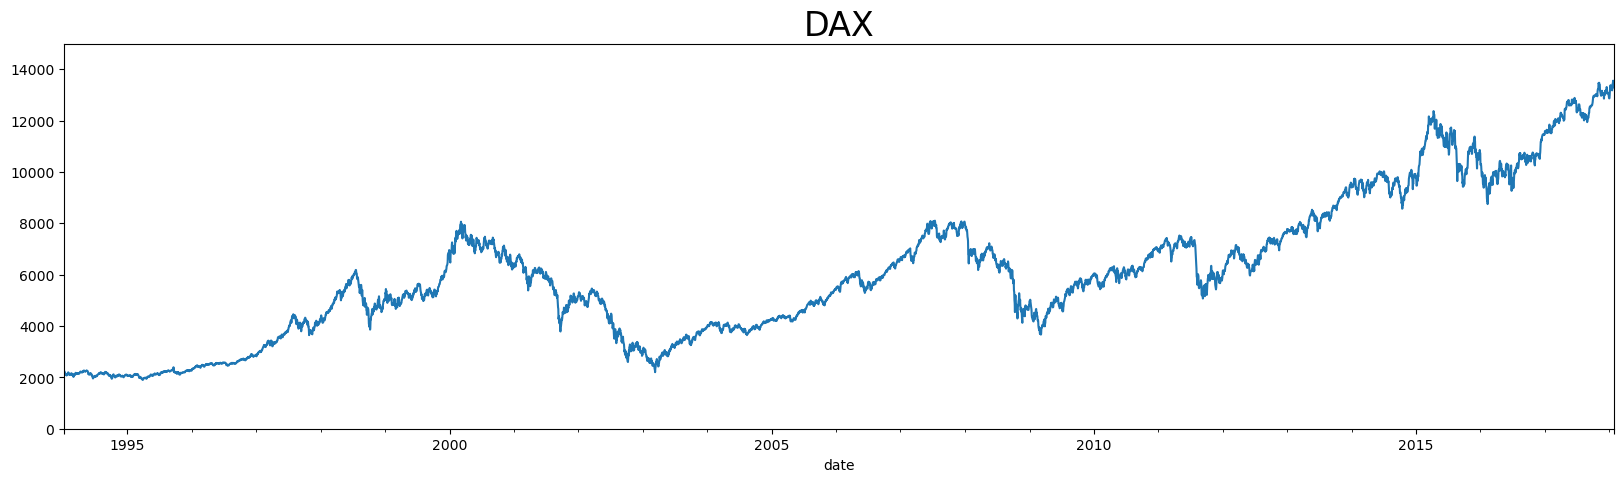

In [151]:
df.valor_mercado.plot(figsize=(20,5))
plt.title("DAX", size = 24)
plt.ylim(0, 15000)
plt.show()

Puntos a destacar:
- **Gran volatilidad**: Hay momentos de alta volatilidad, con caídas muy pronunciadas. Por ejemplo en 2008, probablemente debido a crisis internacional que hubo ese año.
- **Estabilidad antes de caídas**: Observamos que antes de producirse una caída deja de crecer. Es decir, se mantiene constante sin seguir al alza antes de empezar a decrecer.
- **Modelos complejos**: Probablemente esta serie precise de modelos preictivos mas elaborados, ya que presenta una componente de ruido muy elevada. Aunque la tendencia parece creciente, en general hay mucha fluctuación y es impredecible lo que pueda pasar.

Vamos a observar la serie solo en el último año para ver mejor la tendencia.

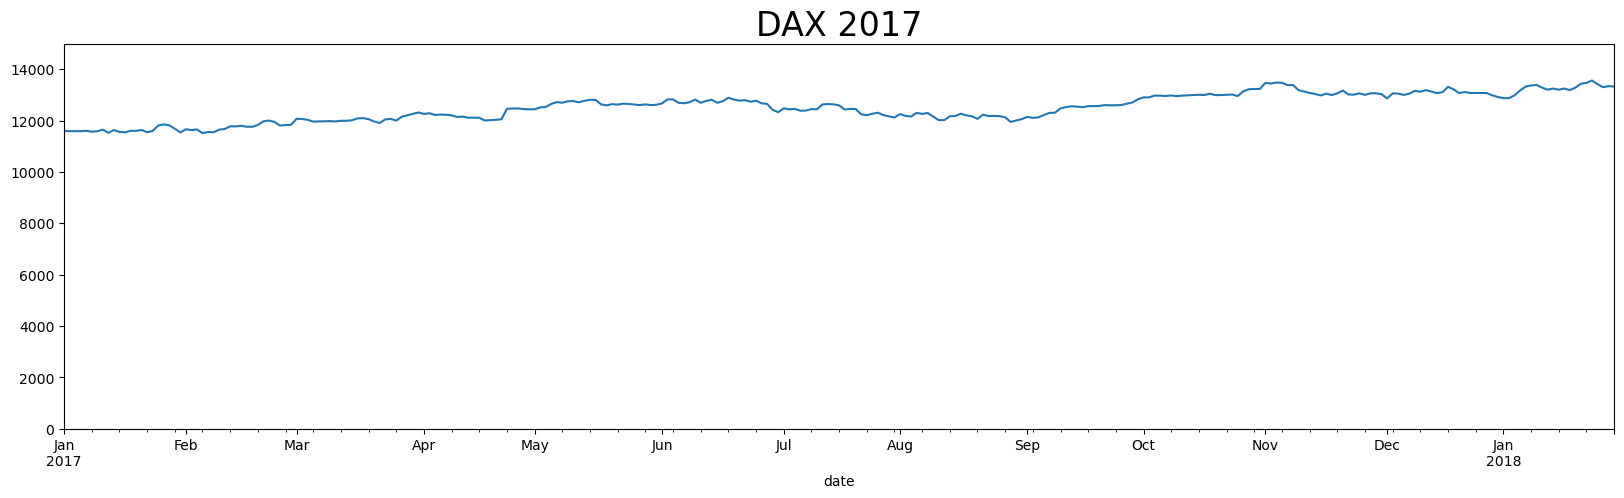

In [152]:
df_filtrado = df[df.index >= '2017-01-01']
df_filtrado['valor_mercado'].plot(figsize=(20, 5))

plt.title("DAX 2017", size=24)
plt.ylim(0, 15000)
plt.show()


Se observa en este último año que se mantiene "constante" (aunque, como ya hemos dicho, con mucha volatilidad). Teniendo en cuenta que viene de crecer y ahora está en fase estable, ¿vendrá después una caída en nuestra predicción? Lo veremos cuando lleguemos a la parte de predicción del futuro.

A continuación descompondremos la serie en sus componentes. Debido a que la serie muestra aumentos en la volatilidad a medida que el índice sube, optamos por la descomposición multiplicativa.

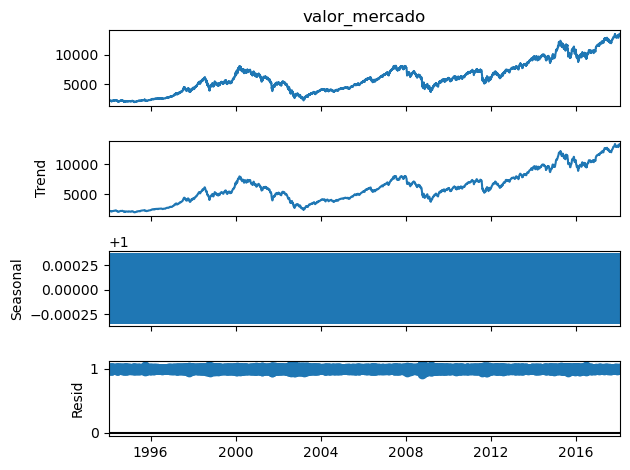

In [153]:
s_dec_mult = seasonal_decompose(df.valor_mercado, model = "multiplicative")
s_dec_mult.plot()
plt.show()

- **Tendencia**: Muestra la serie eliminando fluctuaciones a corto plazo. Observamos que aunque la tendencia parece ligeramente creciente, presenta caídas muy pronunciadas debido probablemente a desastres económicos (crisis del 2000, del 2008, etc).
- **Estacional**: No se detecta una componente estacional significativa. Tiene sentido, ya que los índices bursátiles no suelen presentar patrones estacionales fuertes como otras series económicas.
- **Residual**: Como la descomposición multiplicativa es el producto de los componentes, es normal que estén muy cercanos a 1. Para poder entender mejor esta componente, recurrimos a la descomposición aditiva.

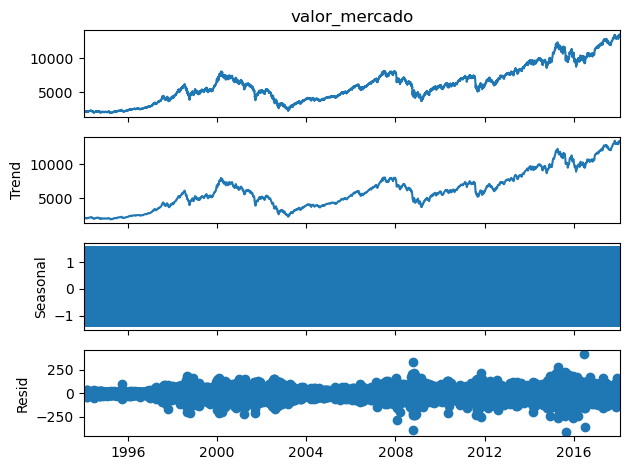

In [154]:
s_dec_aditiva = seasonal_decompose(df.valor_mercado, model = "additive")
s_dec_aditiva.plot()
plt.show()

La distribución de los residuos no presenta patrones claros, lo que significa que la descomposición ha capturado bien la estructura de la serie.

### ESTACIONARIEDAD

Realizaremos el contraste de Dickey-Fuller para ver si nuestra serie es estacionaria o no. Es un contraste de hipótesis, donde:
- **$H_0$**: La serie no es estacionaria ($\phi_1 = 1$)
- **$H_1$**: La serie es estacionaria ($\phi_1 < 1$)

Donde $\phi$ es el coeficiente de autocorrelación de un retraso. 

$\phi_k = corr(x_t, x_{t-k})$

donde k es el retraso entre periodos. Entonces **$\phi_k$** es el coeficiente de autocorrelación de k retrasos.

In [155]:
resultado_test = sts.adfuller(df["valor_mercado"])

tabla = pd.DataFrame({
    "Estadístico ADF": [resultado_test[0]],
    "P-valor": [resultado_test[1]],
    "Nº de rezagos usados": [resultado_test[2]],
    "Nº de observaciones": [resultado_test[3]],
    "Valores críticos (1%)": [resultado_test[4]["1%"]],
    "Valores críticos (5%)": [resultado_test[4]["5%"]],
    "Valores críticos (10%)": [resultado_test[4]["10%"]],
})

tabla 

,Estadístico ADF,P-valor,Nº de rezagos usados,Nº de observaciones,Valores críticos (1%),Valores críticos (5%),Valores críticos (10%)
0,-0.055047,0.953736,5,6271,-3.431393,-2.862001,-2.567015


Si tomamos un nivel de significación del 5%, observamos que como $p-valor = 0.484 > 0.05$, no podemos rechazar $H_0$ y asumimos que la serie no es estacionaria. Lo tendremos en cuenta y aplicaremos diferenciación cuando implantemos modelos que tengan como condición la estacionariedad.

## 2. METODOLOGÍAS CLÁSICAS

Si nos fijamos en el último año (para poder visualizarlo mejor), observamos que captura mejor la tendencia y los cambios en las fluctuaciones del modelo. Sin embargo, sabemos que este modelo no va a ser buen predictor del futuro, ya que el suavizado exponencial es una técnica demasiado básica para una serie tan compleja como esta. Más adelante veremos como combinarlo con metodologías más avanzadas.

### 2.1 MODELO $ARIMA(p, d, q)$

Para elegir el mejor modelo ARIMA, tenemos que visualizar las funciones de autocorrelación de la serie (ACF y PACF), pero primero debemos aplicar diferenciación, ya que vimos que no era estacionaria.

In [156]:
df['valor_mercado_diff'] = df['valor_mercado'].diff(1)

Realizamos de nuevo el ADF test para ver si ya lo hemos logrado estacionariedad.

In [157]:
resultado_test2 = sts.adfuller(df['valor_mercado_diff'][1:])

tabla = pd.DataFrame({
    "Estadístico ADF": [resultado_test2[0]],
    "P-valor": [resultado_test2[1]],
    "Nº de rezagos usados": [resultado_test2[2]],
    "Nº de observaciones": [resultado_test2[3]],
    "Valores críticos (1%)": [resultado_test2[4]["1%"]],
    "Valores críticos (5%)": [resultado_test2[4]["5%"]],
    "Valores críticos (10%)": [resultado_test2[4]["10%"]],
})

tabla 

,Estadístico ADF,P-valor,Nº de rezagos usados,Nº de observaciones,Valores críticos (1%),Valores críticos (5%),Valores críticos (10%)
0,-37.222657,0.0,4,6271,-3.431393,-2.862001,-2.567015


El p-valor es menor que el nivel de significación (5%) y tenemos evidencias suficientes para rechazar $H_0$, por lo que la serie ya es estacionaria y, en el modelo ARIMA, ya sabemos que $d = 1$.

Veamos la serie diferenciada.

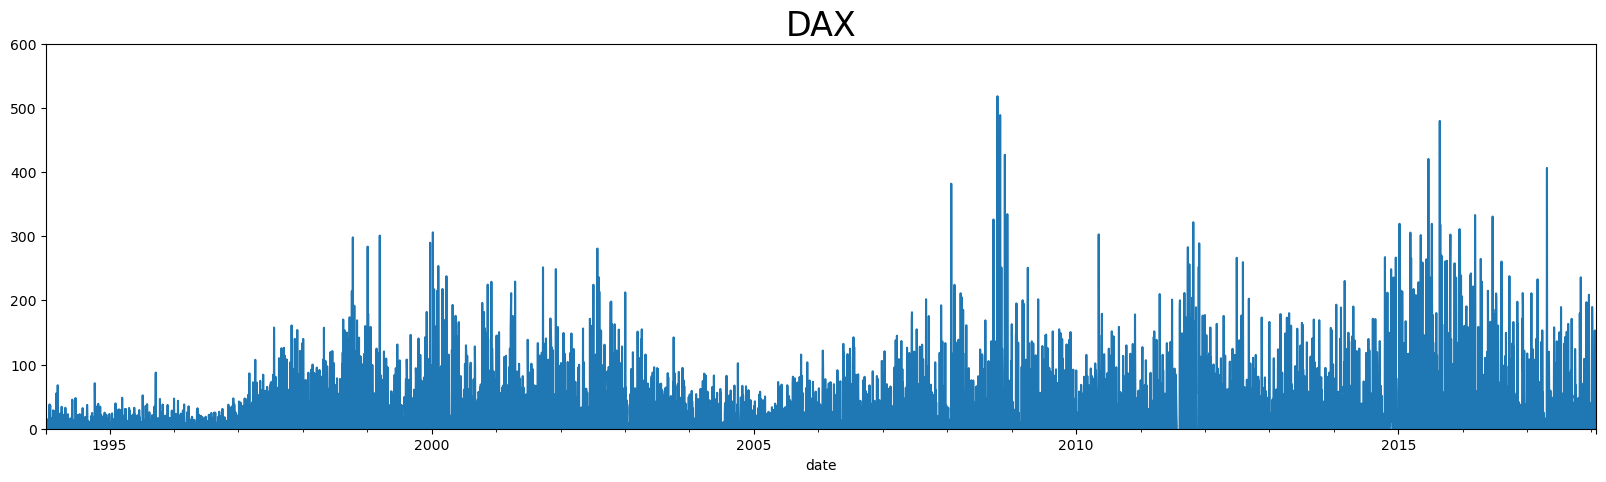

In [158]:
df.valor_mercado_diff.plot(figsize=(20,5))
plt.title("DAX", size = 24)
plt.ylim(0, 600)
plt.show()

#### FUNCIÓN DE AUTOCORRELACIÓN (ACF) Y DE AUTOCORRELACIÓN PARCIAL (PACF)

Calculamos dichas funciones para la serie ya diferenciada. Veremos si nos dan pistas sobre los parámetros del modelo.


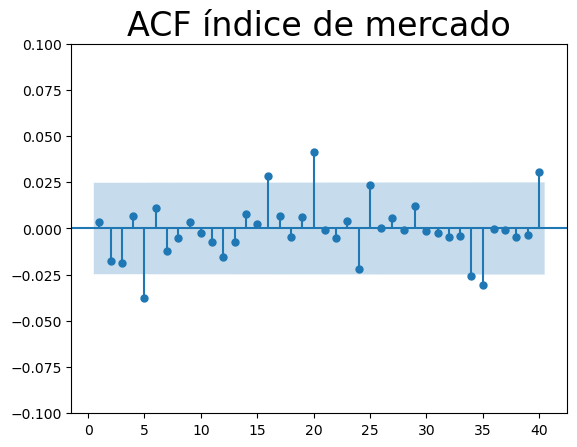

In [159]:
plot_acf(df.valor_mercado_diff[1:], lags = 40, zero = False)
plt.title("ACF índice de mercado", size = 24)
plt.ylim(-0.1, 0.1)
plt.show()

La nube azul representa la significación de los valores de autocorrelación. Es decir, mide si son significativamente distintos de cero; lo que sugiere la existencia de autocorrelación para ese retraso específico. Veamos igual para la PACF.

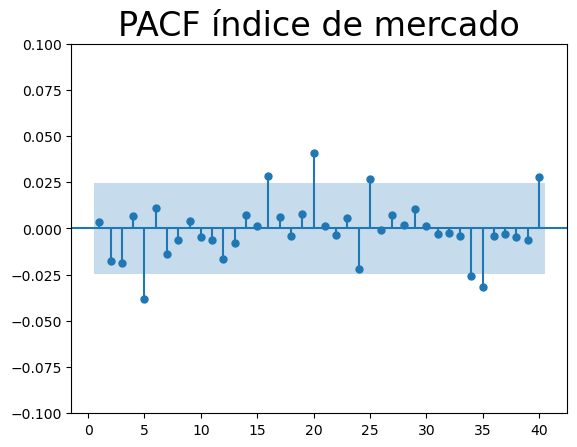

In [160]:
plot_pacf(df.valor_mercado_diff[1:], lags = 40, zero = False)
plt.title("PACF índice de mercado", size = 24)
plt.ylim(-0.1, 0.1)
plt.show()

Ambas funciones son muy parecidas. Vamos a probar varios modelos con las siguientes características.

- **$d = 1$** fijo. Ya hemos visto que con diferenciar una vez la serie, esta es estacionaria.
- **$ p, q \in [1, 4]$** y vemos cuál es el mejor modelo.

Para clasificar los modelos creados, nos atendremos a las siguientes métricas.

-**AIC** (Criterio de Información de Akaike)

-**BIC** (Criterio de Información Bayesiano)

-**RMSE** (Raíz del Error Cuadrático Medio)

In [161]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Rango de valores para p y q
p_values = range(1, 6)
q_values = range(1, 6)

resultados = []

for p in p_values:
    for q in q_values:
        try:
            modelo = ARIMA(df.valor_mercado, order=(p, 1, q))
            modelo_fit = modelo.fit()
            
            predicciones = modelo_fit.predict(start=1, end=len(df.valor_mercado)-1, dynamic=False)
            rmse = np.sqrt(mean_squared_error(df.valor_mercado[1:], predicciones))
            
            resultados.append((p, q, modelo_fit.aic, modelo_fit.bic, rmse))
        except Exception as e:
            continue

resultados_df = pd.DataFrame(resultados, columns=['p', 'q', 'AIC', 'BIC', 'RMSE'])

# Seleccionar los mejores modelos
mejor_modelo_aic = resultados_df.loc[resultados_df['AIC'].idxmin()]
mejor_modelo_bic = resultados_df.loc[resultados_df['BIC'].idxmin()]
mejor_modelo_rmse = resultados_df.loc[resultados_df['RMSE'].idxmin()]

print(resultados_df.sort_values(by=['AIC']).reset_index(drop=True))

print(f"El mejor modelo según AIC es ARIMA({mejor_modelo_aic['p']}, 1, {mejor_modelo_aic['q']}) con AIC: {mejor_modelo_aic['AIC']}")
print(f"El mejor modelo según BIC es ARIMA({mejor_modelo_bic['p']}, 1, {mejor_modelo_bic['q']}) con BIC: {mejor_modelo_bic['BIC']}")
print(f"El mejor modelo según RMSE es ARIMA({mejor_modelo_rmse['p']}, 1, {mejor_modelo_rmse['q']}) con RMSE: {mejor_modelo_rmse['RMSE']}")



    p  q           AIC           BIC       RMSE
0   3  3  73429.352274  73476.563691  83.927817
1   1  5  73429.776691  73476.988108  83.930512
2   5  1  73430.050052  73477.261469  83.932508
3   1  3  73430.883107  73464.605547  83.964842
4   3  4  73430.942670  73484.898574  83.925042
5   4  3  73430.989370  73484.945275  83.924967
6   2  5  73431.716593  73485.672498  83.930172
7   5  2  73432.107621  73486.063526  83.932881
8   1  4  73432.677845  73473.144774  83.963444
9   3  5  73432.795409  73493.495802  83.923941
10  5  3  73432.825040  73493.525433  83.924267
11  4  1  73433.091313  73473.558242  83.966258
12  3  2  73433.112498  73473.579427  83.966397
13  2  3  73433.163815  73473.630743  83.966679
14  2  1  73433.324044  73460.301997  83.994595
15  1  2  73433.342192  73460.320144  83.994715
16  2  4  73433.531188  73480.742604  83.955801
17  4  4  73433.732494  73494.432887  83.930327
18  4  2  73433.872534  73481.083951  83.958100
19  1  1  73433.890975  73454.124439  84

#### MODELO $ARIMA(3,1,3)$

Para comprobar si cumple las hipótesis del modelo, comprobaremos si los residuos son independientes entre sí (si son ruido blanco). Para ello utilizaremos el **test de Ljung-Box**, definido de la siguiente forma:

- $H_0$: Lo residuos son ruido blanco (no hay autocorrelación significativa)
- $H_1$: Los residuos tienen autocorrelación significativa (el modelo no ha capturado bien la estructura de los datos).

In [162]:
modelo_final = ARIMA(df.valor_mercado, order = (3,1,3))
resultados = modelo_final.fit()
resultados.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          valor_mercado   No. Observations:                 6277
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -36707.676
Date:                Thu, 13 Feb 2025   AIC                          73429.352
Time:                        20:37:55   BIC                          73476.564
Sample:                    01-07-1994   HQIC                         73445.710
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7765      0.140     -5.542      0.000      -1.051      -0.502
ar.L2          0.4218      0.197      2.143      0.032       0.036       0.808
ar.L3          0.6100      0.126      4.827      0.000       0.362       0.858
ma.L1          0.7783      0.135      5.748      0.000       0.513       1.044
ma.L2         -0.4390      0.191     -2.295      0.022      -0.814      -0.064
ma.L3         -0.6461      0.123     -5.274      0.000      -0.886      -0.406
sigma2      7040.9119     72.539     97.064      0.000    6898.738    7183.086
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              4525.00
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               2.27   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**CONCLUSIONES**

- **Coeficientes significativos**: Todos los coeficientes (tanto los AR como los MA) son significativos porque los p-valores asociados son menores que el nivel de significación (0.05).
- **Test de Ljung-Box**: Como p-valor = 0.00 < 0.05, no hay evidencias para rechazar $H_0$ y asumimos que no hay correlaciones entre los residuos.
- **Prueba de Jarque-Bera**: Los residuos no siguen una distribución normal. Típico de series financieras.
- **Sigma2 = 3391.2744**: Variabilidad muy alta en nuestros datos (alta volatilidad). Probaremos con otros modelos que capturen bien dicha volatilidad (GARCH)

Veamos como predice nuestro modelo.

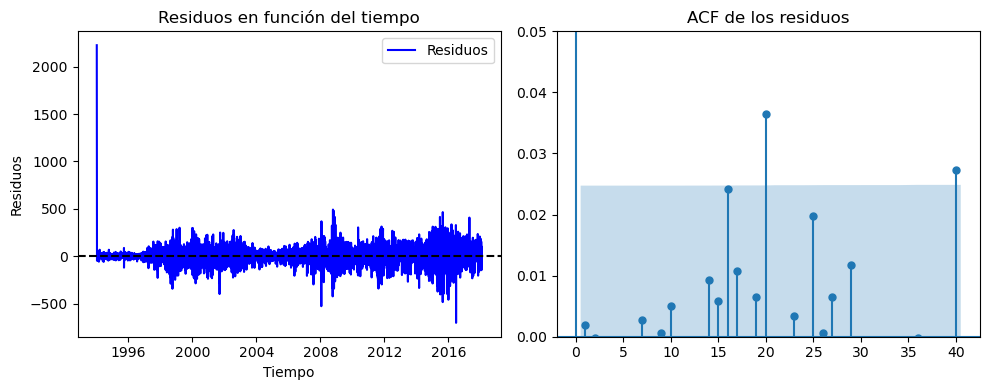

In [163]:
#----- Obtenemos los residuos del modelo ------#
residuos = resultados.resid

#------ Creamos la figuta -------#
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

#------ Gráfico 1: Residuos a lo largo del tiempo ------#
axes[0].plot(residuos, label="Residuos", color="blue")
axes[0].axhline(y=0, color="black", linestyle="--")
axes[0].set_title("Residuos en función del tiempo")
axes[0].set_xlabel("Tiempo")
axes[0].set_ylabel("Residuos")
axes[0].legend()

#------- Gráfico 2: ACF de los residuos -------#
plot_acf(residuos, ax=axes[1], lags=40)
plt.ylim(0,0.05)
axes[1].set_title("ACF de los residuos")

plt.tight_layout()
plt.show()

Vemos ahora como predice el modelo seleccionado.

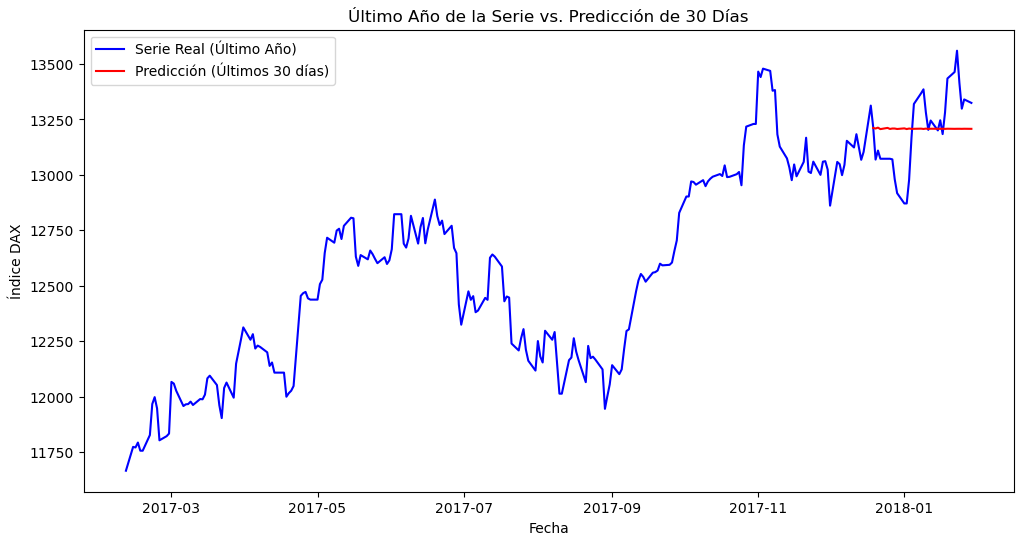

In [164]:
#----- Particionamos el conjunto de datos ------#

X_train = df['valor_mercado'].iloc[:6248] 
X_test = df['valor_mercado'].iloc[6247:]

#----- Seleccionamos y entrenamos el modelo con X_train------#
arima = ARIMA(X_train, order = (3,1,3))
result = arima.fit()

#----- Predecimos los valores correspondientes a X_test ------#
start = len(X_train)
end = len(X_train) + len(X_test) -1 
pred_arima = result.predict(start=start, end=end)

#----- Seleccionamos las fechas necesarias ------#

ultimo_año = df.index[-252:]  # 252 días hábiles (~1 año)
datos_reales = df.valor_mercado[-252:]  # Último año de valores reales

fechas_pred = df.index[-30:]  
pred_ultimos_30 = pred_arima[-30:]

#----- Graficamos la figura ------#
plt.figure(figsize=(12, 6))
plt.plot(ultimo_año, datos_reales, label="Serie Real (Último Año)", color="blue")

plt.plot(fechas_pred, pred_ultimos_30, label="Predicción (Últimos 30 días)", color="red")

plt.xlabel("Fecha")
plt.ylabel("Índice DAX")
plt.title("Último Año de la Serie vs. Predicción de 30 Días")
plt.legend()
plt.show()

In [ ]:
#------ Calculamos métricas de error -----#
mae = mean_absolute_error(X_test, pred_arima)
rmse = np.sqrt(mean_squared_error(X_test, pred_arima))
mape = np.mean(np.abs((X_test - pred_arima) / X_test)) * 100
r2 = r2_score(X_test, pred_arima)

print(f"MAE ARIMA: {mae:.4f}")
print(f"RMSE ARIMA: {rmse:.4f}")
print(f"MAPE ARIMA: {mape:.2f}%")
print(f"R^2 ARIMA: {r2:.4f}")


MAE ARIMA: 144.8232
RMSE ARIMA: 176.0141
MAPE ARIMA: 1.14%
R^2 ARIMA: -0.0052


Vemos que el modelo no ha capturado bien la tendencia de la serie. Esto puede deberse, como hemos comentado antes, a la alta volatilidad de los datos. Por ello, vamos a probar con un modelo que capte bien dicha variabilidad en los datos.

## 3. MODELOS HÍBRIDOS

### 3.1 MODELO $GARCH(1,1) + ARIMA (3,1,3)$

Probaremos con el modelo más simple, con $p=1$ y $q=1$. El objetivo de este modelo es **modelar la volatilidad** (no predecir los retornos directamente), para después poder combinarlo con el ARIMA y ver si mejoran nuestras predicciones.

**$GARCH(1,1)$**

Veamos como funciona este modelo por separado, tratando de predecir los retornos de la serie.

In [166]:
#----- Calculamos los retornos ------#
df['retornos'] = df.valor_mercado.pct_change(1)*100

#----- Entrenamos el modelo con los retornos ------#
garch = arch_model(df.retornos[1:], mean= 'Constant', vol = 'GARCH', p=1, q=1)
result_garch = garch.fit(update_freq = 5)
result_garch.summary()

Iteration:      5,   Func. Count:     35,   Neg. LLF: 10133.358315821413
Iteration:     10,   Func. Count:     64,   Neg. LLF: 10079.185911166527
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10079.185908117724
            Iterations: 12
            Function evaluations: 73
            Gradient evaluations: 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:               retornos   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -10079.2
Distribution:                  Normal   AIC:                           20166.4
Method:            Maximum Likelihood   BIC:                           20193.3
                                        No. Observations:                 6276
Date:                Thu, Feb 13 2025   Df Residuals:                     6275
Time:                        20:38:03   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0835  1.366e-02      6.110  9.937e-10 [5.671e-02,  0.110]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0199  4.678e-03      4.244  2.192e-05 [1.069e-02,2.903e-02]
alpha[1]       0.0831  8.942e-03      9.292  1.512e-20   [6.557e-02,  0.101]
beta[1]        0.9073  9.416e-03     96.351      0.000     [  0.889,  0.926]
============================================================================

Covariance estimator: robust
"""

**CONCLUSIONES DEL MODELO**

- El coeficiente **$\mu$ = 0.0835** es estadísticamente significativo (p-valor ≈ 0.000), lo que sugiere que el retorno medio es ligeramente mayor que cero.
- **$\omega$ = 0.0199**: Representa la varianza incondicional. Un valor positivo (que además es significativo) sugiere que hay volatilidad base en los retornos.
- **$\alpha$ = 0.0831**: Es significativo, lo que indica que los eventos recientes afectan a la volatilidad en el futuro.
- **$\beta$ =0.9073**: También significativo. Cuando es cercano a 1, indica que la volatilidad elevada tiende a persistir en el tiempo.
- **$\alpha + \beta$ = 0.9904**: Indica proceso altamente persistente, pero sin explosión. Si fuera mayor que 1, el modelo no sería estacionario.



In [167]:
modelo_arima = ARIMA(df.valor_mercado, order=(3,1,3))
resultados_arima = modelo_arima.fit()

df['residuos_arima'] = resultados_arima.resid

garch = arch_model(df['residuos_arima'][1:], mean='Zero', vol='GARCH', p=1, q=1)
result_garch = garch.fit(update_freq=5)

print(resultados_arima.summary())


Iteration:      5,   Func. Count:     24,   Neg. LLF: 35375.10725623064
Iteration:     10,   Func. Count:     47,   Neg. LLF: 35181.384933492314
Optimization terminated successfully    (Exit mode 0)
            Current function value: 35181.384933492314
            Iterations: 11
            Function evaluations: 50
            Gradient evaluations: 11
                               SARIMAX Results                                
Dep. Variable:          valor_mercado   No. Observations:                 6277
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -36707.676
Date:                Thu, 13 Feb 2025   AIC                          73429.352
Time:                        20:38:09   BIC                          73476.564
Sample:                    01-07-1994   HQIC                         73445.710
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
             

In [168]:
print(result_garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:         residuos_arima   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -35181.4
Distribution:                  Normal   AIC:                           70368.8
Method:            Maximum Likelihood   BIC:                           70389.0
                                        No. Observations:                 6276
Date:                Thu, Feb 13 2025   Df Residuals:                     6276
Time:                        20:38:09   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          4.8064      2.253      2.133  3.289e-02    

### 3.1 HÍBRIDO ARIMA(3,1,3) + GARCH(1,1)

MAE ARIMA + GARCH: 195.4469
RMSE ARIMA + GARCH: 224.1971
MAPE ARIMA + GARCH: 1.52%
R^2 ARIMA + GARCH: -0.6309


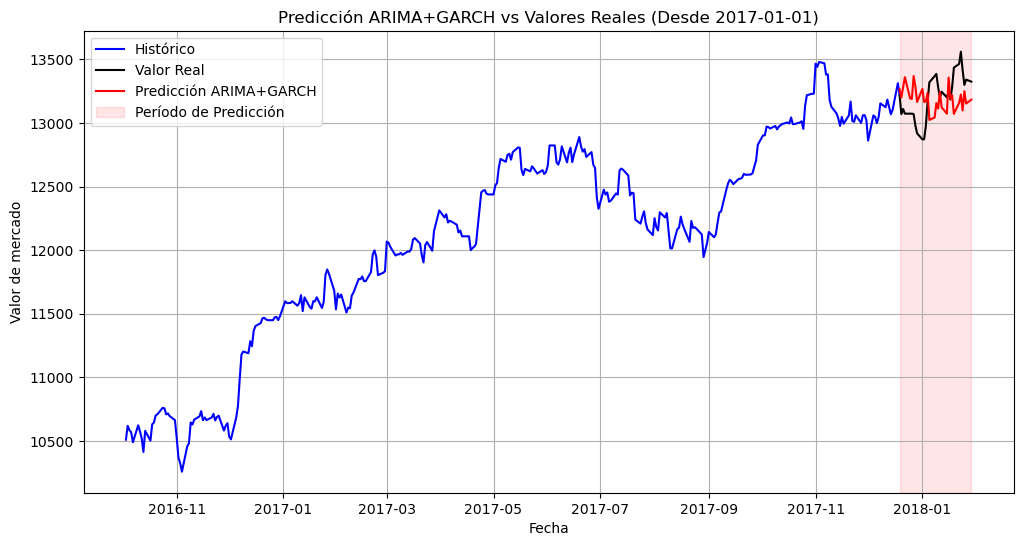

In [169]:
#-----Aplicamos el modelo ARIMA(3,1,3) igual que antes ------#
modelo_arima = ARIMA(X_train, order=(3,1,3))
result_arima = modelo_arima.fit()
pred_arima = result_arima.predict(start=len(X_train), end=len(X_train)+len(X_test)-1)
pred_arima = pred_arima + (X_train.iloc[-1] - pred_arima.iloc[0])

#----- Extraemos los residuos y los entrenamos con el modelo GARCH(1,1) ------#
residuos_arima = result_arima.resid

garch = arch_model(residuos_arima, mean='AR', vol='GARCH', p=1, q=1)
resultado_garch = garch.fit(disp='off')

garch_pred = resultado_garch.forecast(horizon=len(X_test))
volatilidad_predicha = np.sqrt(garch_pred.variance.values[-1, :])

#-------- Simulamos ruido garch a partir de la volatilidad predicha -------#
np.random.seed(42)
ruido_garch = np.random.normal(0, volatilidad_predicha, len(X_test)) 

#----- Calculamos las predicciones finales ------#
pred_final_arima_garch = pred_arima + ruido_garch

plt.figure(figsize=(12, 6))

#----- Graficamos la serie histórica desde 2017-01-01 -----#
plt.plot(X_train.loc["2016-10-01":].index, X_train.loc["2016-10-01":], label="Histórico", color="blue")
plt.plot(X_test.index, X_test, label="Valor Real", color="black")
plt.plot(X_test.index, pred_final_arima_garch, label="Predicción ARIMA+GARCH", color="red")
plt.axvspan(X_test.index[0], X_test.index[-1], color="red", alpha=0.1, label="Período de Predicción")

plt.xlabel("Fecha")
plt.ylabel("Valor de mercado")
plt.title("Predicción ARIMA+GARCH vs Valores Reales (Desde 2017-01-01)")
plt.legend()
plt.grid()

#----- Métricas de evaluación ------#
mae = mean_absolute_error(X_test, pred_final_arima_garch)
rmse = np.sqrt(mean_squared_error(X_test, pred_final_arima_garch))
mape = np.mean(np.abs((X_test - pred_final_arima_garch) / X_test)) * 100
r2 = r2_score(X_test, pred_final_arima_garch)

print(f"MAE ARIMA + GARCH: {mae:.4f}")
print(f"RMSE ARIMA + GARCH: {rmse:.4f}")
print(f"MAPE ARIMA + GARCH: {mape:.2f}%")
print(f"R^2 ARIMA + GARCH: {r2:.4f}")


Capta mejor la volatilidad y se va pareciendo más a los valores reales. Sin embargo las métricas no son buenas.

### 3.3 MODELO ARIMA(3,1,3) + MLP (PERCEPTRÓN MULTICAPA)

Probamos con un modelo mediante redes neuronales.

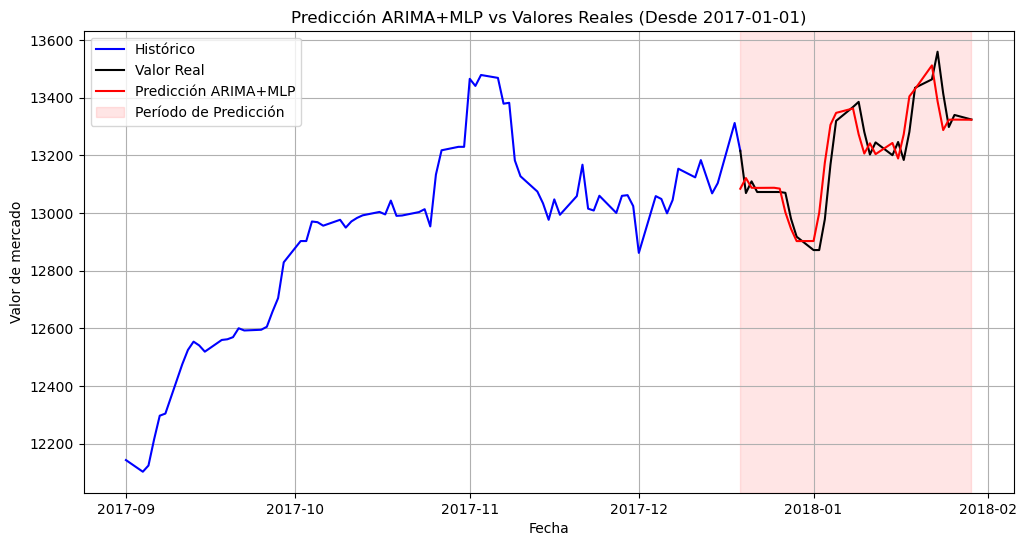

MAE ARIMA + MLP: 62.1917
RMSE ARIMA + MLP: 82.0130
MAPE ARIMA + MLP: 0.13%
R^2 ARIMA + MLP: 0.7818


In [170]:
#-----Modelado ARIMA igual que antes y extracción de los residuos ------#
modelo_arima = ARIMA(X_train, order=(3, 1, 3))
result_arima = modelo_arima.fit()

pred_arima = result_arima.predict(start=len(X_train), end=len(X_train) + len(X_test) - 1)
residuos_arima = X_test - pred_arima

#----- Eliminamos NaN y separamos los residuos en X,Y------#
residuos_arima = residuos_arima.dropna()

X_residuos = residuos_arima[:-1].values.reshape(-1, 1)  
y_residuos = residuos_arima[1:].values.reshape(-1, 1)  

#----- Aplicamos el modelo MLP con los residuos y entrenamos ------#
mlp_model = MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
mlp_model.fit(X_residuos, y_residuos)

pred_residuos_mlp = mlp_model.predict(residuos_arima[:-1].values.reshape(-1, 1))
pred_residuos_mlp = np.append(pred_residuos_mlp, pred_residuos_mlp[-1])

#----- Si es menor el tamaño, relleamos con el anterior (por si da problemas el último) ------#
if len(pred_residuos_mlp) < len(pred_arima):
    pred_residuos_mlp = np.append(pred_residuos_mlp, pred_residuos_mlp[-1])

#----- Predicciones finales ------#
pred_final_arima_mlp = pred_arima + pred_residuos_mlp

#----------GRÁFICA---------#

plt.figure(figsize=(12, 6))
plt.plot(X_train.loc["2017-09-01":].index, X_train.loc["2017-09-01":], label="Histórico", color="blue")
plt.plot(X_test.index, X_test, label="Valor Real", color="black")
plt.plot(X_test.index, pred_final_arima_mlp, label="Predicción ARIMA+MLP", color="red")
plt.axvspan(X_test.index[0], X_test.index[-1], color="red", alpha=0.1, label="Período de Predicción")
plt.xlabel("Fecha")
plt.ylabel("Valor de mercado")
plt.title("Predicción ARIMA+MLP vs Valores Reales (Desde 2017-01-01)")
plt.legend()
plt.grid()
plt.show()

#----- Métricas de evaluación ------#
mae = mean_absolute_error(X_test, pred_final_arima_mlp)
rmse = np.sqrt(mean_squared_error(X_test, pred_final_arima_mlp))
mape = np.mean(np.abs((X_test - pred_final_arima_mlp) / X_test)) * 100
r2 = r2_score(X_test, pred_final_arima_mlp)

print(f"MAE ARIMA + MLP: {mae:.4f}")
print(f"RMSE ARIMA + MLP: {rmse:.4f}")
print(f"MAPE ARIMA + MLP: {mape:.2f}%")
print(f"R^2 ARIMA + MLP: {r2:.4f}")

Vamos a verlo más de cerca, aunque tiene muy buena pinta.

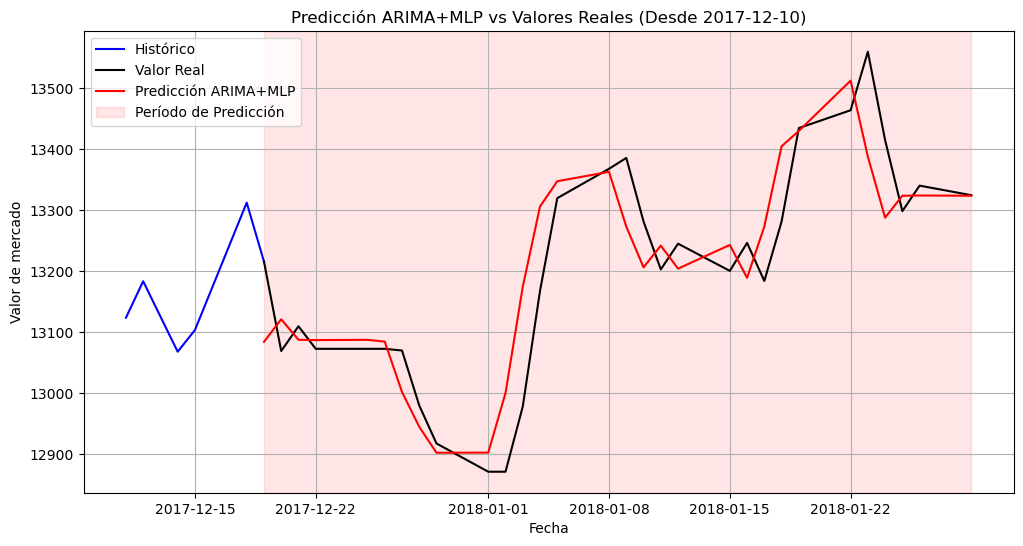

In [171]:
#----- Reducimos la ventana de observación en fechas ------#

plt.figure(figsize=(12, 6))
plt.plot(X_train.loc["2017-12-10":].index, X_train.loc["2017-12-10":], label="Histórico", color="blue")
plt.plot(X_test.index, X_test, label="Valor Real", color="black")
plt.plot(X_test.index, pred_final_arima_mlp, label="Predicción ARIMA+MLP", color="red")
plt.axvspan(X_test.index[0], X_test.index[-1], color="red", alpha=0.1, label="Período de Predicción")
plt.xlabel("Fecha")
plt.ylabel("Valor de mercado")
plt.title("Predicción ARIMA+MLP vs Valores Reales (Desde 2017-12-10)")
plt.legend()
plt.grid()
plt.show()


Veamos un último modelo.

### 3.3 ARIMA (3,1,3) + LSTM

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


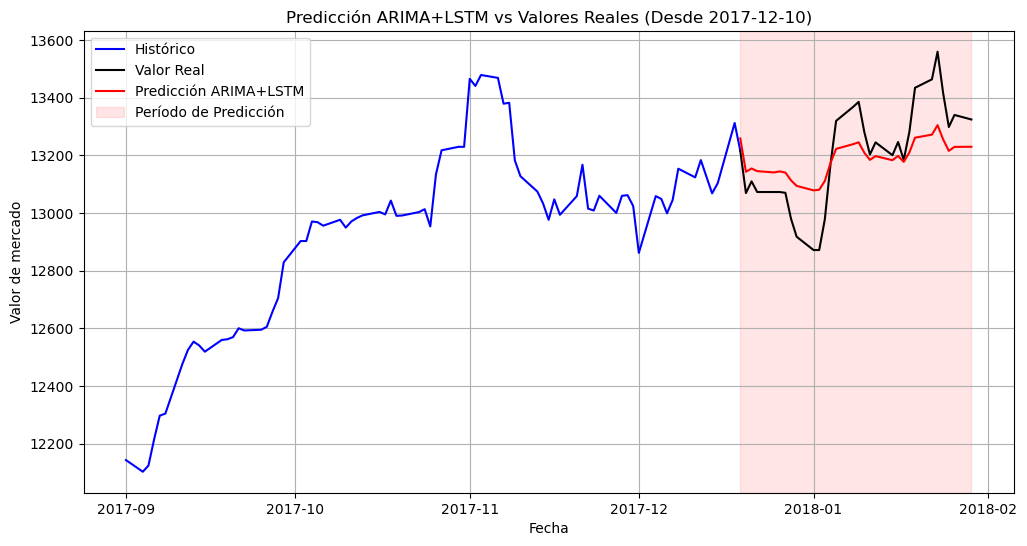

MAE ARIMA + LSTM: 100.8100
RMSE ARIMA + LSTM: 119.6091
MAPE ARIMA + LSTM: 0.76%
R^2 ARIMA + LSTM: 0.5358


In [172]:
#-----Modelado ARIMA igual que antes y extracción de los residuos ------#
modelo_arima = ARIMA(X_train, order=(3, 1, 3))
result_arima = modelo_arima.fit()

pred_arima = result_arima.predict(start=X_test.index[0], end=X_test.index[-1])
residuos_arima = X_test - pred_arima

residuos_arima_values = residuos_arima.values.reshape(-1, 1)

#-----Normalizamos los residuos y creamos los datos lstm ------#
scaler = MinMaxScaler(feature_range=(0, 1))
residuos_normalizados = scaler.fit_transform(residuos_arima_values)

def crear_datos_lstm(data, time_steps=1):
    X, y = [], []
    for i in range(len(data)-time_steps):
        X.append(data[i:i+time_steps, 0])
        y.append(data[i+time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 1
X_residuos_lstm, y_residuos_lstm = crear_datos_lstm(residuos_normalizados, time_steps)

X_residuos_lstm = X_residuos_lstm.reshape((X_residuos_lstm.shape[0], X_residuos_lstm.shape[1], 1))

#----- Creamos el modelo -----#

modelo_lstm = Sequential()
modelo_lstm.add(LSTM(units=50, return_sequences=False, input_shape=(X_residuos_lstm.shape[1], 1)))
modelo_lstm.add(Dense(units=1))
modelo_lstm.compile(optimizer='adam', loss='mean_squared_error')

#---- Entrenamos el modelo -----#
modelo_lstm.fit(X_residuos_lstm, y_residuos_lstm, epochs=100, batch_size=32, verbose=0)

residuos_test = residuos_arima.values.reshape(-1, 1)
residuos_test_normalizados = scaler.transform(residuos_test)

X_residuos_lstm_test, _ = crear_datos_lstm(residuos_test_normalizados, time_steps)
X_residuos_lstm_test = X_residuos_lstm_test.reshape((X_residuos_lstm_test.shape[0], X_residuos_lstm_test.shape[1], 1))

pred_residuos_lstm_normalizado = modelo_lstm.predict(X_residuos_lstm_test)

pred_residuos_lstm = scaler.inverse_transform(pred_residuos_lstm_normalizado)

pred_residuos_lstm = np.append(pred_residuos_lstm, pred_residuos_lstm[-1])  

#------ Predicciones finales -------#
pred_final_arima_lstm = pred_arima + pred_residuos_lstm

#------ GRÁFICA ------#
plt.figure(figsize=(12, 6))
plt.plot(X_train.loc["2017-09-01":].index, X_train.loc["2017-09-01":], label="Histórico", color="blue")
plt.plot(X_test.index, X_test, label="Valor Real", color="black")
plt.plot(X_test.index, pred_final_arima_lstm, label="Predicción ARIMA+LSTM", color="red")
plt.axvspan(X_test.index[0], X_test.index[-1], color="red", alpha=0.1, label="Período de Predicción")
plt.xlabel("Fecha")
plt.ylabel("Valor de mercado")
plt.title("Predicción ARIMA+LSTM vs Valores Reales (Desde 2017-12-10)")
plt.legend()
plt.grid()
plt.show()

#---- Métricas de evaluación -----#
mae = mean_absolute_error(X_test, pred_final_arima_lstm)
rmse = np.sqrt(mean_squared_error(X_test, pred_final_arima_lstm))
mape = np.mean(np.abs((X_test - pred_final_arima_lstm) / X_test)) * 100
r2 = r2_score(X_test, pred_final_arima_lstm)

print(f"MAE ARIMA + LSTM: {mae:.4f}")
print(f"RMSE ARIMA + LSTM: {rmse:.4f}")
print(f"MAPE ARIMA + LSTM: {mape:.2f}%")
print(f"R^2 ARIMA + LSTM: {r2:.4f}")




Buen modelo, aunque ligeramente peor que el anterior.